In [1]:
import json
import os
import numpy as np

In [2]:
def import_metrics_json(models_path, run_num):
    """
    Looks in {models_path}/{run_num}/metrics.json and returns the contents as a
    Python dictionary. Returns None if the path does not exist.
    """
    path = os.path.join(models_path, str(run_num), "metrics.json")
    if not os.path.exists(path):
        return None
    with open(path, "r") as f:
        return json.load(f)

In [3]:
def get_best_metric(models_path, metric_name, reduce_func, compare_func):
    """
    Given the path to a set of runs, determines the run with the best metric value,
    for the given `metric_name`. For each run, the function `reduce_func` must take
    the array of all values for that metric and return a (scalar) value to use for
    comparison. The best metric value is determined by `metric_compare_func`, which
    must take in two arguments, and return whether or not the _first_ one is better.
    Returns the number of the run, the value associated with that run, and a dict of
    all the values used for comparison.
    """
    # Get the metrics, ignoring empty or nonexistent metrics.json files
    metrics = {run_num : import_metrics_json(models_path, run_num) for run_num in os.listdir(models_path)}
    metrics = {key : val for key, val in metrics.items() if val}  # Remove empties
    
    # Get the best value
    best_run, best_val, all_vals = None, None, {}
    for run_num in metrics.keys():
        try:
            val = reduce_func(metrics[run_num][metric_name]["values"])
            all_vals[run_num] = val
            if best_val is None or compare_func(val, best_val):
                best_val, best_run = val, run_num
        except Exception:
            print("Warning: Was not able to compute values for run %s" % run_num)
            continue
    return best_run, best_val, all_vals

In [4]:
def get_best_metric_at_best_epoch(models_path, metric_name, reduce_func, compare_func):
    """
    Given the path to a set of runs, determines the run with the best metric value,
    for the given `metric_name`. For each run, the function `reduce_func` must take
    the array of all values for that metric and return a (scalar) value FOR EACH
    SUBARRAY/VALUE in the value array to use for comparison. The best metric value
    is determined by `metric_compare_func`, which must take in two arguments, and
    return whether or not the _first_ one is better.
    Returns the number of the run, the (one-indexed) number of the epch, the value
    associated with that run and epoch, and a dict of all the values used for
    comparison (mapping pair of run number and epoch number to value).
    """
    # Get the metrics, ignoring empty or nonexistent metrics.json files
    metrics = {run_num : import_metrics_json(models_path, run_num) for run_num in os.listdir(models_path)}
    metrics = {key : val for key, val in metrics.items() if val}  # Remove empties
    
    # Get the best value
    best_run, best_epoch, best_val, all_vals = None, None, None, {}
    for run_num in metrics.keys():
        try:
            # Find the best epoch within that run
            best_epoch_in_run, best_val_in_run = None, None
            for i, subarr in enumerate(metrics[run_num][metric_name]["values"]):
                val = reduce_func(subarr)
                if best_val_in_run is None or compare_func(val, best_val_in_run):
                    best_epoch_in_run, best_val_in_run = i + 1, val
            all_vals[(run_num, best_epoch_in_run)] = best_val_in_run
            
            # If the best value in the best epoch of the run is best so far, update
            if best_val is None or compare_func(best_val_in_run, best_val):
                best_run, best_epoch, best_val = run_num, best_epoch_in_run, best_val_in_run
        except Exception:
            print("Warning: Was not able to compute values for run %s" % run_num)
            continue
    return best_run, best_epoch, best_val, all_vals

In [5]:
def print_validation_profile_and_prior_losses(condition):
    models_path = "/users/amtseng/att_priors/models/trained_models/profile_models/%s/" % condition
    
    print("Best profile loss overall:")
    best_run, best_epoch, best_val, all_vals = get_best_metric_at_best_epoch(
        models_path,
        "val_prof_corr_losses",
        lambda values: np.mean(values),
        lambda x, y: x < y
    )
    print("\tBest run: %s" % best_run)
    print("\tBest epoch in run: %d" % best_epoch)
    print("\tAssociated value: %s" % best_val)
    
    print("Best epoch in each run:")
    for key in sorted(all_vals.keys(), key=lambda p: int(p[0])):
        print("\tRun %s, epoch %d: %6.2f" % (key[0], key[1], all_vals[key]))
        
    print("All validation profile and prior losses:")
    for key in sorted(all_vals.keys(), key=lambda p: int(p[0])):
        print(key[0])
        metrics = import_metrics_json(models_path, key[0])
        print("\t" + " ".join(["%6.2f" % i for i in np.mean(metrics["train_prof_corr_losses"]["values"], axis=1)]))
        print("\t" + " ".join(["%6.2f" % i for i in np.mean(metrics["val_prof_corr_losses"]["values"], axis=1)]))
        print("\t" + " ".join(["%6.4f" % i for i in np.mean(metrics["val_att_losses"]["values"], axis=1)]))
    return all_vals

In [67]:
noprior_vals = print_validation_profile_and_prior_losses("SPI1_keep1")

Best profile loss overall:
	Best run: None


TypeError: %d format: a number is required, not NoneType

In [61]:
prior_vals = print_validation_profile_and_prior_losses("HepG2_prior_attconstant_attweight20_freqlimit200_limitsoft0.8")

Best profile loss overall:
	Best run: 4
	Best epoch in run: 7
	Associated value: 182.0987248357137
Best epoch in each run:
	Run 1, epoch 9: 182.95
	Run 2, epoch 9: 183.29
	Run 3, epoch 10: 182.55
	Run 4, epoch 7: 182.10
All validation profile and prior losses:
1
	202.23 197.78 196.21 195.31 194.73 194.42 194.23 194.04 193.90 193.86
	187.73 185.57 184.65 184.16 183.55 183.37 183.21 183.04 182.95 183.15
	0.1383 0.1452 0.1211 0.1374 0.1389 0.1360 0.1277 0.1306 0.1296 0.1266
2
	202.29 197.63 195.99 195.24 194.80 194.52 194.27 194.09 193.95 193.78
	187.86 185.76 185.01 184.53 183.94 183.96 183.71 183.49 183.29 183.51
	0.1250 0.1262 0.1487 0.1316 0.1301 0.1249 0.1220 0.1263 0.1275 0.1184
3
	201.74 197.30 196.05 195.25 194.86 194.65 194.47 194.25 194.14 194.01
	186.36 184.89 184.00 183.52 183.19 183.07 182.85 182.75 182.62 182.55
	0.1376 0.1099 0.1164 0.1393 0.1283 0.1348 0.1314 0.1180 0.1093 0.1085
4
	202.49 197.73 196.05 195.16 194.63 194.38 194.13 193.95
	187.20 184.47 183.65 182.85 182.72

In [8]:
import matplotlib.pyplot as plt
import scipy.stats

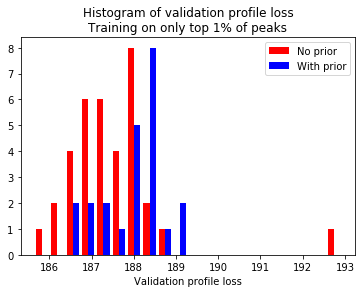

In [52]:
bin_num = 20
plt.figure()
plt.hist(
    [np.array(list(noprior_vals.values())), np.array(list(prior_vals.values()))],
    bin_num, histtype="bar",
    label=["No prior", "With prior"], color=["red", "blue"])
title = "Histogram of validation profile loss"
title += "\nTraining on only top 1% of peaks"
plt.title(title)
plt.xlabel("Validation profile loss")
plt.legend()

In [10]:
np_vals, p_vals = np.array(list(noprior_vals.values())), np.array(list(prior_vals.values()))
t, p = scipy.stats.ttest_ind(np_vals, p_vals)
print(t)
print(p / 2)

-1.4935238069267553
0.07631127294129736
